# Import libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':'tight'}
plt.rcParams["figure.figsize"] = [15, 8]
import numpy as np
from numpy.random import uniform, seed
import pandas as pd
from time import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# 1. (40 pts) Define functions
### Define the following functions

In [2]:
def one_hot_encode(labels):
    """
        Turn single digit numerical value classes into length 10 vectors...
        1 for the positive class and 0's for the other 9 negative classes.
    """
    
    min_l, max_l = min(labels), max(labels)
    one_hot_map = {k: [0 if i < k else 1 if i == k else 0 \
                              for i in range(min_l, max_l+1)] \
                      for k in range(min_l, max_l+1)}
    
    return np.matrix([one_hot_map[label[0]] for label in labels]).reshape(-1, 10)
    
def sigmoid(z):
    """
        Squishes the output of our hypothesis function into the range (0, 1).
    """
       
    exp = np.exp(z)
    return exp/(exp+1)

def softmax(z):
    """
        Produce confidence probabilities for the output classes.
    """

    exp = np.exp(z)
    return exp/exp.sum(axis=1).reshape(-1, 1)
    
def eval_softmax(weights, data, labels):
    """
        Convert softmax activations into well-defined outputs; evaluate accuracy using labels.
    """
    
    net = {'weights': weights}
    s_max = softmax(forward(net, data))

    # Apply mask to accentuate softmax output
    test_mask = np.where(s_max == s_max.max(axis=1).reshape(-1, 1), 1, 0)

    return sum([1 if (test_mask[i]==l).all() else 0 for i, l in enumerate(labels)])/len(labels)*100
    
def log_loss(output, labels):
    """
        Computes the log loss when provided with the output from the final activation layer
        and the corresponding labeled data.
    """
    
    output = output.clip(min=1e-10, max=0.9999999999)
    
    return (-1/labels.shape[0]) * np.sum(np.multiply(labels, np.log(output)) + np.multiply((1-labels), np.log(1-output)))
    
def forward(net, X):
    """
        Perform forward propagation through our neural network. Apply sigmoid to 
        pre-activation signals.
    """
    
    # Retrieve weights from the network and reinitialize the cached activations
    W1 = net['weights'][0]
    W2 = net['weights'][1]
    net['activations'] = []
           
    # Perform forward pass while appyling bias terms to the input and a1 layers
    X_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)   
    a1 = sigmoid(np.dot(W1, X_bias.T))                              
    a1_bias = np.concatenate((a1, np.ones((1, X.shape[0]))), axis=0) 
    a2 = sigmoid(np.dot(W2, a1_bias)).T    
    
    # Cache input data and activations
    net['input'] = X  
    net['activations'].append(a1)
    net['activations'].append(a2)
                
    return a2
    
def backward(net, labels):
    """
        Perform back propagation through our neural network. Compute error derivatives
        w.r.t. parameter and bias weights.
    """
    
    # Retrieve input data, cached activations, and weights from the network
    X = net['input']
    a1 = net['activations'][0]
    a2 = net['activations'][1]
    W1 = net['weights'][0][:, :-1]
    W2 = net['weights'][1][:, :-1]

    # Compute loss function derivatives w.r.t. parameters and biases
    dL_dW2 = (1/X.shape[0]) * np.dot(a1, (a2-labels)).T
    dL_db2 = (1/X.shape[0]) * np.sum((a2-labels), axis=0, keepdims=True).T
    dL_dW1 = (1/X.shape[0]) * np.dot(np.multiply(np.dot((a2-labels), W2).T, (a1 * (1-a1))), X)
    dL_db1 = (1/X.shape[0]) * np.sum(np.multiply(np.dot((a2-labels), W2).T, (a1 * (1-a1))), axis=1, keepdims=True)   
        
    return dL_dW1, dL_db1, dL_dW2, dL_db2
        
def gradient_descent(net, X, labels, alpha, iters, suppress_output=False):
    """
        Use loss function derivatives w.r.t weights to continually improve the
        performace of our network.
    """
      
    def update_weights(weights, gradients):
        W1, b1 = weights[0][:, :-1], weights[0][:, -1].reshape(-1, 1)
        W2, b2 = weights[1][:, :-1], weights[1][:, -1].reshape(-1, 1)
        
        W1 -= alpha * gradients[0]
        b1 -= alpha * gradients[1]
        W2 -= alpha * gradients[2]
        b2 -= alpha * gradients[3]  
        
    new_cost, old_cost = log_loss(forward(net, X), labels), float('inf')    
    beginning = start = time()
    count = 0
    
    if not suppress_output:
        print('Initial cost:', new_cost)

    while count < iters:
        update_weights(net['weights'], backward(net, labels))
        old_cost = new_cost
        new_cost = log_loss(forward(net, X), labels)
        if not suppress_output:
            if time() - start > 10:
                print('\t', new_cost)
            start = time()
        count += 1
     
    elapsed = time() - beginning
    train_loss = old_cost
    test_loss = log_loss(forward(net, x_test), y_test)
        
    if not suppress_output:
        print('Model has a log loss of {}\n\tachieved in {} iterations in {} seconds with a learning rate of {}'.format(
                train_loss, iters, elapsed, alpha))
    
    return (train_loss, test_loss, elapsed)

# 2. (5 pts) Split data
### Split training and testing data into x and y sets. Input has columns from 0 to 399 and ouput has a column 'y'

In [3]:
train = pd.read_csv('ex3_train.csv')
test = pd.read_csv('ex3_test.csv')

x_train = train.iloc[:, :-1].as_matrix()
x_test = test.iloc[:, :-1].as_matrix()

# One hot encode labels
y_train = one_hot_encode(train.iloc[:, -1].values.reshape(-1, 1))
y_test = one_hot_encode(test.iloc[:, -1].values.reshape(-1, 1))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


# 3. (5 pts) Initialize parameters
### Use np.random.seed(1) when initializing weight coefficients. Set bias terms to 0.

In [4]:
# Form weight matrices by concatenating zeroed bias weights to randomly initialized parameter weights
seed(1); W1_init = np.concatenate((uniform(-1, 1, (25, x_train.shape[1])), np.zeros((25, 1))), axis=1)
seed(1); W2_init = np.concatenate((uniform(-1, 1, (y_train.shape[1], 25)), np.zeros((y_train.shape[1], 1))), axis=1)
W1 = np.copy(W1_init)
W2 = np.copy(W2_init)

# 4. (20 pts) Neural network model with one hidden layer
### Build a neural network model, using the training set, with an input layer of 400 neurons, one hidden layer of 25 neurons, and an output layer of 10 neurons.

In [5]:
net = {'weights': [W1, W2],
       'activations': []
      }

train_loss, test_loss, elapsed_time = gradient_descent(net, x_train, y_train, alpha=1, iters=50)

Initial cost: 10.86632526
Model has a log loss of 1.6830669761065125
	achieved in 50 iterations in 1.2818758487701416 seconds with a learning rate of 1


# 5. (10 pts) Predictions
### Predict digits using the softmax function. Calculate the accuracy of the predictions using both the training and testing data.

In [6]:
train_max = softmax(forward(net, x_train))
test_max = softmax(forward(net, x_test))

# Apply mask to accentuate softmax output
train_mask = np.where(train_max == train_max.max(axis=1).reshape(-1, 1), 1, 0)
test_mask =  np.where(test_max == test_max.max(axis=1).reshape(-1, 1), 1, 0)

train_score = sum([1 if (train_mask[i]==l).all() else 0 for i, l in enumerate(y_train)])/len(y_train)*100
test_score = sum([1 if (test_mask[i]==l).all() else 0 for i, l in enumerate(y_test)])/len(y_test)*100
        
print('Training score: {}\nTesting score: {}'.format(round(train_score, 2), round(test_score, 2)))

Training score: 75.86
Testing score: 74.6


# 6. (20 pts) Optimization
### Optimize the model using a variety of learning rates and number of iterations.

In [7]:
models = []
learning_rates = [10, 1.72, 1, 0.1]
num_iters = [50, 100, 250, 500, 1000]

# Train a bunch of models
for a in learning_rates:
    print('Training models with a learning rate of {} for iterations:\n\t'.format(a), end=' ')
    for i in num_iters:
        print(i, end='  ')
        net['weights'][0], net['weights'][1] = np.copy(W1_init), np.copy(W2_init)
        l, l2, t = gradient_descent(net, x_train, y_train, alpha=a, iters=i, suppress_output=True)
        models.append({
            'train_loss': l,
            'test_loss': l2,
            'time': t,
            'alpha': a,
            'iters': i,
            'weights': [np.copy(w) for w in net['weights']]
        })
    print()
print('Done.')

Training models with a learning rate of 10 for iterations:
	 50  100  250  500  1000  
Training models with a learning rate of 1.72 for iterations:
	 50  100  250  500  1000  
Training models with a learning rate of 1 for iterations:
	 50  100  250  500  1000  
Training models with a learning rate of 0.1 for iterations:
	 50  100  250  500  1000  
Done.


### Plot the cost over the number of iterations with different learning rates for the training set.

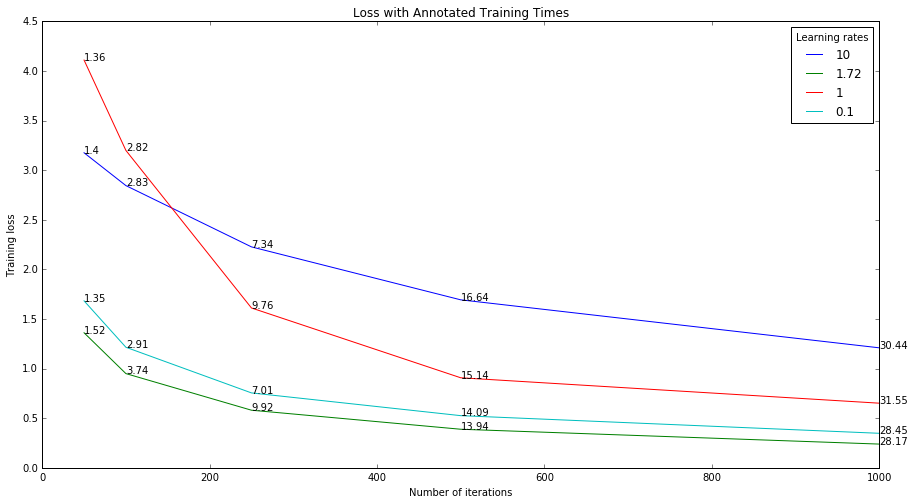

In [8]:
# Organize `loss over # iterations` plot lines for learning rates
data = {
    lr: 
        sorted(list(filter(lambda x: x['alpha'] == lr, models)), key=lambda x: x['iters'])
    for lr in learning_rates
}

# Create plot lines for learning rates and annotate with training times
lines = []
for lr, d in data.items():
    evals = [x['train_loss'] for x in d]
    times = [x['time'] for x in d]
    lines.append(plt.plot(num_iters, evals, label=str(lr))[0])
    for i, t in enumerate(times):
        plt.annotate(str(round(t, 2)), (num_iters[i], evals[i]))

# Format plot
plt.legend(lines, learning_rates, title='Learning rates')  
plt.xlabel('Number of iterations')
plt.ylabel('Training loss')
plt.title('Loss with Annotated Training Times')

### Print the optimized accuracy for the test set.

	# iterations | train accuracy | test accuracy
Learning rate: 0.1
		50  	  20.43 	  22.13
		100  	  33.23 	  34.73
		250  	  61.20 	  61.40
		500  	  75.06 	  75.67
		1000  	  83.60 	  83.13
Learning rate: 1.72
		50  	  81.29 	  80.33
		100  	  87.29 	  86.00
		250  	  92.63 	  88.80
		500  	  95.14 	  91.07
		1000  	  97.49 	  92.40
Learning rate: 10
		50  	  28.80 	  28.60
		100  	  41.97 	  40.73
		250  	  70.31 	  69.20
		500  	  85.00 	  80.47
		1000  	  94.71 	  87.47
Learning rate: 1
		50  	  75.86 	  74.60
		100  	  83.37 	  82.07
		250  	  89.69 	  87.53
		500  	  92.89 	  89.80
		1000  	  95.86 	  91.20
The best model:
	Learning rate: 1.72
	# of iterations: 1000
	Training time: 28.17042136
	Training loss: 0.23910645
	Test loss: 0.5729091
	Training accuracy: 97.48571429
	Test accuracy: 92.4



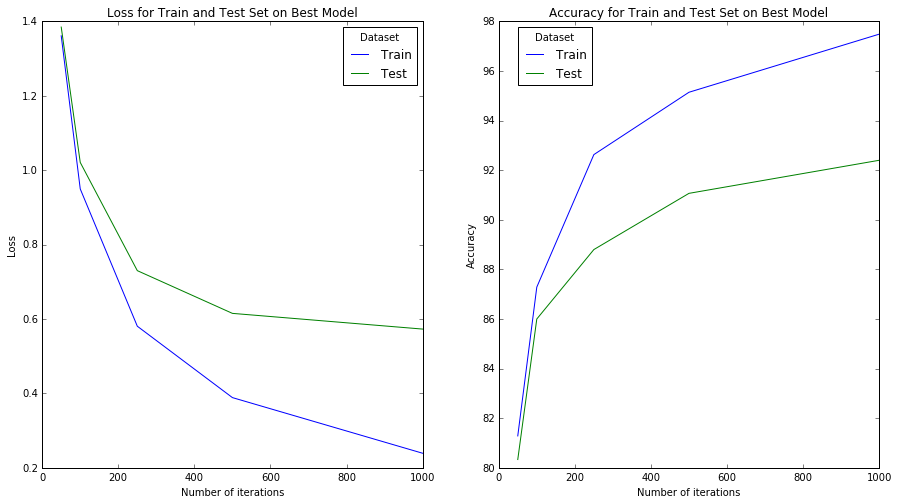

In [9]:
# Print the train and test accuracy for every combination of alpha and # of iterations
models_with_evals = []
print('\t# iterations | train accuracy | test accuracy')
for lr, dat in data.items():
    print('Learning rate:', lr)
    for d in dat:
        train_score = eval_softmax(d['weights'], x_train, y_train)
        test_score = eval_softmax(d['weights'], x_test, y_test)
        models_with_evals.append((train_score, test_score, d, dat))
        print('\t\t{}  \t  {:.2f} \t  {:.2f}'.format(d['iters'], round(train_score, 2), round(test_score, 2)))
        
# Print details about the model with the highest test accuracy
best = max(models_with_evals, key=lambda x: x[1])
print('The best model:\n\tLearning rate: {}\n\t# of iterations: {}\n\tTraining time: {}\n\tTraining loss: {}\n\tTest loss: {}\n\tTraining accuracy: {}\n\tTest accuracy: {}\n'.format(
    best[2]['alpha'], best[2]['iters'], *[round(b, 8) for b in [best[2]['time'], best[2]['train_loss'], best[2]['test_loss'], best[0], best[1]]]
))

# Create plot data for train/test loss/accuracy of the best model
train_scores, train_losses, test_scores, test_losses = [], [], [], []
for d in best[-1]:
        train_scores.append(eval_softmax(d['weights'], x_train, y_train))
        test_scores.append(eval_softmax(d['weights'], x_test, y_test))
        train_losses.append(d['train_loss'])
        test_losses.append(d['test_loss'])

# Plot the train/test loss for the best model
fig = plt.figure()
plt.subplot(121)
lines = []
for d in [train_losses, test_losses]:
    lines.append(plt.plot(num_iters, d)[0])
plt.legend(lines, ['Train', 'Test'], title='Dataset')  
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss for Train and Test Set on Best Model')

# Plot the train/test accuracy for the best model
plt.subplot(122)
lines = []
for d in [train_scores, test_scores]:
    lines.append(plt.plot(num_iters, d)[0])
plt.legend(lines, ['Train', 'Test'], title='Dataset', bbox_to_anchor=(0.26, 1))  
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy for Train and Test Set on Best Model')